In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import time
import matplotlib.pyplot as plt

# import wandb
# wandb.login()

#Variables
batch_size = 32
learning_rate = 1e-3
epochs = 20

# wandb.init(project="Autoencoder",
#            config={
#                "batch_size": batch_size,
#                "learning_rate": learning_rate,
#                "dataset": "MNIST",
#            })


# Get cpu or gpu device for training.
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)

#Printing data
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

class AutoEncoder(nn.Module):
    def __init__(self,):
        super(AutoEncoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = torch.nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)         
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid()            
        )



    def forward(self, x):
        x = self.flatten(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


model = AutoEncoder().to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # model.train()
    for (image, _) in dataloader:
    # for batch, (X, y) in enumerate(dataloader):
    
        # Compute prediction and loss
        image = image.reshape(-1, 28*28)
        image = image.to(device)
        # X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        pred = model(image)
        loss = loss_fn(pred, image)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, torch.reshape(X, (pred.shape)))
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    # wandb.log({"loss": test_loss})
    # wandb.watch(model)
    # correct /= size
    print(f"Avg loss: {test_loss:>8f} \n")




Using cuda device
Shape of X [N, C, H, W]:  torch.Size([32, 1, 28, 28])
Shape of y:  torch.Size([32]) torch.int64


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# %%wandb

#Timing the hardware difference
tic = time.perf_counter()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

toc = time.perf_counter()
if {device} == "cpu":
    print(f"CPU time {toc - tic:0.4f} seconds")
else:
    print(f"GPU time {toc - tic:0.4f} seconds")

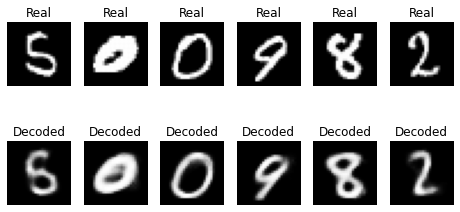

In [5]:
figure = plt.figure(figsize=(8, 4))
cols, rows = 6, 2
for i in range(1, cols +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img_dev = img.to(device)
    pred_dev = model(img_dev)
    pred = torch.reshape(pred_dev,[28,28])
    pred = pred.to("cpu")
    pred = pred.detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title("Real")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    figure.add_subplot(rows, cols, i+cols)
    plt.title("Decoded")
    plt.axis("off")
    plt.imshow(pred.squeeze(), cmap="gray")
plt.show()

In [6]:

torch.save(model, 'model.pth')
torch.save(model.state_dict(), 'model_weights.pth')
